In [22]:
import pandas as pd

# Đọc dữ liệu từ file CSV đã tải lên
file_path = "filtered_data_northern_vietnam.csv"
df = pd.read_csv(file_path)

# Hiển thị một số dòng đầu để kiểm tra dữ liệu
df.head()


,Unnamed: 0,DATE,STATION,TMAX,TMIN,TAVG,PRCP,YEAR,MONTH,SEASON
0,4051,2013-01-01,VMM00048840,61,54,59,0.00,2013,1,Winter
1,4052,2013-01-04,VMM00048840,59,54,56,0.00,2013,1,Winter
2,4053,2013-01-05,VMM00048840,56,52,54,0.01,2013,1,Winter
3,4054,2013-01-06,VMM00048840,54,52,53,0.05,2013,1,Winter
4,4055,2013-01-07,VMM00048840,57,53,55,0.00,2013,1,Winter


In [23]:
# Chuyển đổi nhiệt độ từ độ F sang độ C
df['TMAX'] = round((df['TMAX'] - 32) / 1.8, 1)
df['TMIN'] = round((df['TMIN'] - 32) / 1.8, 1)
df['TAVG'] = round((df['TAVG'] - 32) / 1.8, 1)
df

,Unnamed: 0,DATE,STATION,TMAX,TMIN,TAVG,PRCP,YEAR,MONTH,SEASON
0,4051,2013-01-01,VMM00048840,16.1,12.2,15.0,0.00,2013,1,Winter
1,4052,2013-01-04,VMM00048840,15.0,12.2,13.3,0.00,2013,1,Winter
2,4053,2013-01-05,VMM00048840,13.3,11.1,12.2,0.01,2013,1,Winter
3,4054,2013-01-06,VMM00048840,12.2,11.1,11.7,0.05,2013,1,Winter
4,4055,2013-01-07,VMM00048840,13.9,11.7,12.8,0.00,2013,1,Winter
...,...,...,...,...,...,...,...,...,...,...
7613,28657,2024-09-11,VMM00048806,27.2,21.1,22.8,0.00,2024,9,Autumn
7614,28658,2024-09-12,VMM00048806,27.8,20.6,23.9,0.00,2024,9,Autumn
7615,28659,2024-09-14,VMM00048806,28.9,21.1,24.4,0.00,2024,9,Autumn
7616,28660,2024-09-15,VMM00048806,31.7,20.6,26.1,0.00,2024,9,Autumn


In [24]:
# Xác định các mùa dựa trên MONTH (nếu chưa có SEASON)
if 'SEASON' not in df.columns:
    conditions = [
        df['MONTH'].isin([2, 3, 4]),  # Xuân
        df['MONTH'].isin([5, 6, 7]),  # Hạ
        df['MONTH'].isin([8, 9, 10]),  # Thu
        df['MONTH'].isin([11, 12, 1])  # Đông
    ]
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    df['SEASON'] = pd.Series(seasons).iloc[pd.concat([pd.Series(c) for c in conditions], axis=1).idxmax(axis=1)].values
    df


In [25]:

# Tính nhiệt độ trung bình, tối đa, tối thiểu theo mùa từng năm
seasonal_stats = df.groupby(['YEAR', 'SEASON']).agg(
    TAVG_mean=('TAVG', 'mean'),
    TMAX_max=('TMAX', 'max'),
    TMIN_min=('TMIN', 'min'),
    TEMP_range=('TAVG', lambda x: x.max() - x.min())
).reset_index()

# Làm tròn các giá trị
seasonal_stats = seasonal_stats.round(1)
seasonal_stats.head()


,YEAR,SEASON,TAVG_mean,TMAX_max,TMIN_min,TEMP_range
0,2013,Autumn,25.8,37.2,11.1,13.3
1,2013,Spring,22.2,35.6,8.3,18.8
2,2013,Summer,27.6,39.4,16.1,12.7
3,2013,Winter,16.7,32.2,1.1,21.1
4,2014,Autumn,26.6,37.8,14.4,12.2


In [26]:
# Hàm xác định giá trị nhiệt độ cực đoan (outliers) theo mùa
def calculate_seasonal_outliers(df, column):
    df['IS_OUTLIER'] = False  # Cột mặc định là False
    for (year, season), group in df.groupby(['YEAR', 'SEASON']):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
        df.loc[(df['YEAR'] == year) & (df['SEASON'] == season) & outliers, 'IS_OUTLIER'] = True
    return df


In [27]:
# Xác định tần suất xuất hiện nhiệt độ cực đoan theo mùa
df = calculate_seasonal_outliers(df, 'TAVG')
extreme_temp_counts = df[df['IS_OUTLIER']].groupby(['YEAR', 'SEASON']).size().reset_index(name='extreme_count')

# Kết hợp với bảng seasonal_stats
seasonal_stats = seasonal_stats.merge(extreme_temp_counts, on=['YEAR', 'SEASON'], how='left')
seasonal_stats['extreme_count'] = seasonal_stats['extreme_count'].fillna(0).astype(int)



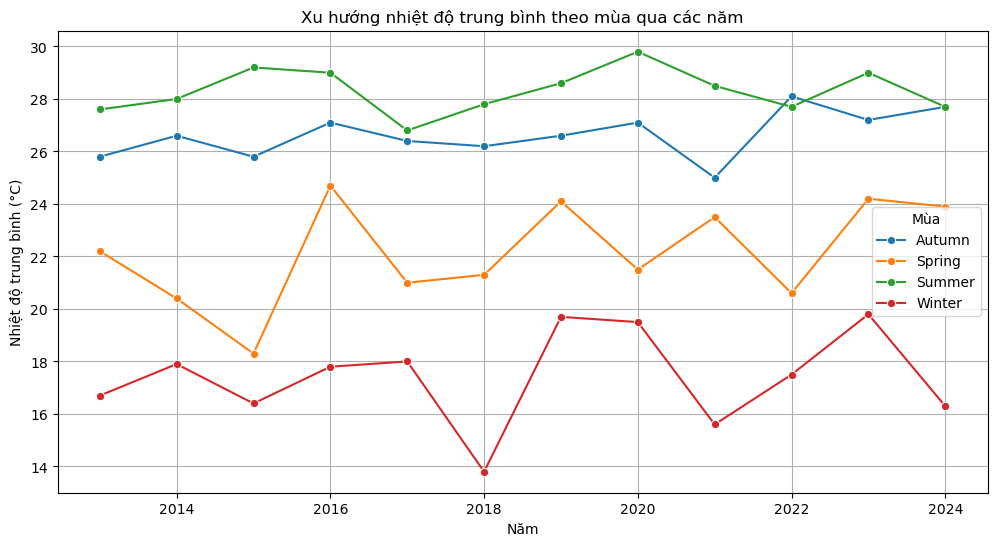

In [28]:

# Vẽ các biểu đồ phân tích xu hướng
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ 1: Xu hướng nhiệt độ trung bình theo mùa qua các năm
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_stats, x='YEAR', y='TAVG_mean', hue='SEASON', marker='o')
plt.title('Xu hướng nhiệt độ trung bình theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend(title='Mùa')
plt.grid(True)
plt.show()


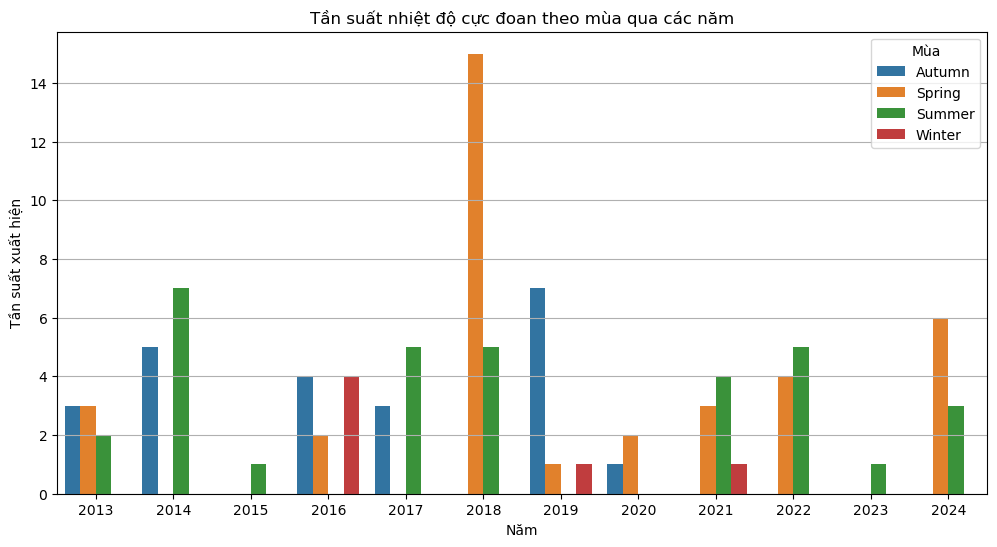

In [29]:
# Biểu đồ 2: So sánh tần suất nhiệt độ cực đoan giữa các mùa
plt.figure(figsize=(12, 6))
sns.barplot(data=seasonal_stats, x='YEAR', y='extreme_count', hue='SEASON')
plt.title('Tần suất nhiệt độ cực đoan theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Tần suất xuất hiện')
plt.legend(title='Mùa')
plt.grid(axis='y')
plt.show()


C:\Users\WIN 10\AppData\Local\Temp\ipykernel_5152\1823728399.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=seasonal_stats, x='SEASON', y='TEMP_range', palette='coolwarm')


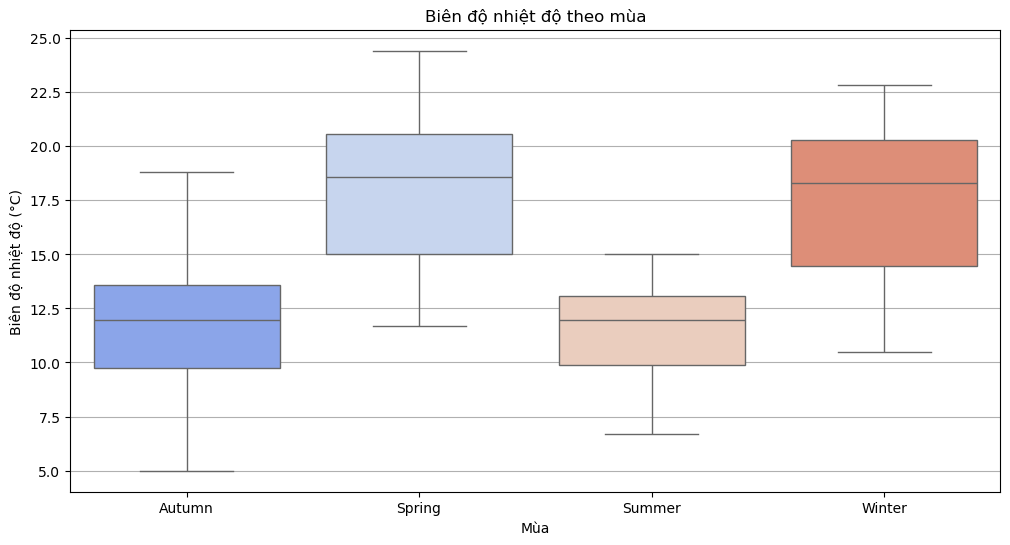

In [30]:

# Biểu đồ 3: So sánh biên độ nhiệt độ giữa các mùa
plt.figure(figsize=(12, 6))
sns.boxplot(data=seasonal_stats, x='SEASON', y='TEMP_range', palette='coolwarm')
plt.title('Biên độ nhiệt độ theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Biên độ nhiệt độ (°C)')
plt.grid(axis='y')
plt.show()